## 데이콘 기본 코드

In [1]:
import pandas as pd
train_x_df = pd.read_csv('data/train_x_df.csv')
train_y_df = pd.read_csv('data/train_y_df.csv')
test_x_df = pd.read_csv('data/test_x_df.csv')
train_x_df.head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,9,0.983614,0.983614,0.983128,0.983246,0.001334,10.650987,0.009855,0.000848,6.771755
1,0,1,9,0.983245,0.983612,0.982453,0.982693,0.001425,11.375689,0.016137,0.000697,5.565188
2,0,2,9,0.982694,0.983612,0.982403,0.983002,0.001542,12.301942,0.014166,0.000905,7.225459
3,0,3,9,0.983009,0.984848,0.983009,0.984486,0.002520,20.134695,0.021557,0.001171,9.353000
4,0,4,9,0.984233,0.984606,0.983612,0.984164,0.002818,22.515448,0.021434,0.001799,14.372534


In [2]:
import numpy as np
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1] # 10
    time_size = len(df_2d.time.value_counts()) # x는 1380, y는 120
    sample_size = len(df_2d.sample_id.value_counts()) # train은 7661, test는 535
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    # array_3d의 각 차원의 의미: (sample_id, time, feature)
    return array_3d

train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7661, 1380, 10)
train_y_array (7661, 120, 10)
test_x_array (535, 1380, 10)



In [3]:
import matplotlib.pyplot as plt
#입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
def plot_series(x_series, y_series):
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

/Users/duru/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


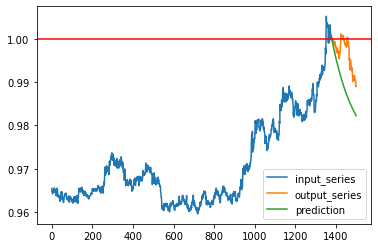

In [4]:
from statsmodels.tsa.arima.model import ARIMA
idx = 1121
# train data 중 sample_id 1121에 해당하는 x_series로 arima 모델을 학습한 후
# y_sereis를 추론
x_series = train_x_array[idx,:,1]
y_series = train_y_array[idx,:,1]

# ARIMA의 (p,d,q) 값은 최적화 되지않은 값 입니다.
model = ARIMA(x_series, order=(3,0,1)) 
fit  = model.fit()
preds = fit.predict(1381, 1500, typ='levels')

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), preds, label = 'prediction')
plt.legend()
plt.show()

In [5]:
# train 데이터 상단의 N개 샘플로 validation set를 구성하여 학습 및 추론
val_samp_size = 1000
valid_x_df = train_x_df[train_x_df.sample_id < val_samp_size]
valid_y_df = train_y_df[train_y_df.sample_id < val_samp_size]

valid_x_array = df2d_to_array3d(valid_x_df)
valid_y_array = df2d_to_array3d(valid_y_df)
valid_pred_array = np.zeros([val_samp_size, 120])

In [6]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

# ARIMA의 (p,d,q) 값이 (3,1,3)에서 수렴하지 않을 경우
# (2,1,2)로 변경하여 다시 학습 및 추론
for idx in tqdm(range(valid_x_array.shape[0])):
    try:
        try:
            x_series = valid_x_array[idx,:,1]
            model = ARIMA(x_series, order=(2,1,2))
            fit  = model.fit()
            preds = fit.predict(1381,1500, typ='levels')
            valid_pred_array[idx,:] = preds  # - (preds[0]-x_series[-1])
        except:
            x_series = valid_x_array[idx,:,1]
            model = ARIMA(x_series, order=(3,1,3))
            fit  = model.fit()
            preds = fit.predict(1381,1500, typ='levels')
            valid_pred_array[idx,:] = preds
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        # ARIMA의 (p,d,q) 값이 (2,1,2), (3,1,3)에서 수렴하지 않을 경우
        # 모두 0으로 채움
        pass

100%|██████████| 1000/1000 [09:04<00:00,  1.84it/s]


In [13]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
    buy_price = np.array(buy_price)
    # 상승한다고 예측한 sample에 대해서만 100% 매수
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.001) * 1
    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

valid_submission = array_to_submission(valid_x_array, valid_pred_array)
valid_submission

,sample_id,buy_quantity,sell_time
0,0,0,0
1,1,0,0
2,2,0,7
3,3,0,1
4,4,0,0
...,...,...,...
995,995,0,0
996,996,0,1
997,997,0,0
998,998,0,2


In [14]:
# 전체 300가지 sample에 대해
# 상승한다고 추론한 수.
valid_submission.buy_quantity.value_counts()

0    980
1     20
Name: buy_quantity, dtype: int64

In [15]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

total_momey, total_momey_list = COIN(valid_y_df, valid_submission)
# 투자 후 금액
print(total_momey)

10101.115419877244


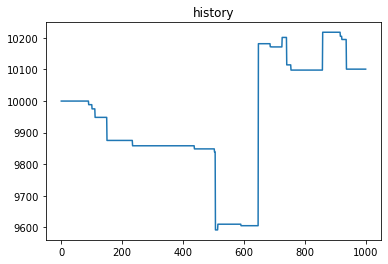

In [16]:
# 투자 히스토리
plt.plot(total_momey_list)
plt.title("history")
plt.show()

In [ ]:
test_pred_array = np.zeros([test_x_array.shape[0],
                           120])
for idx in tqdm(range(test_x_array.shape[0])):
    try:
        try:
            x_series = test_x_array[idx,:,1]

            model = ARIMA(x_series, order=(3,1,2))
            fit  = model.fit()
            preds = fit.predict(1381,1500, typ='levels')
            test_pred_array[idx,:] = preds
        except:
            x_series = test_x_array[idx,:,1]
            model = ARIMA(x_series, order=(4,1,2))
            fit  = model.fit()
            preds = fit.predict(1381,1500, typ='levels')
            test_pred_array[idx,:] = preds
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

In [ ]:
submission = array_to_submission(test_x_array, test_pred_array)
# 시즌 2 부터는 test_x_df의 sample_id가 train_x_df의 sample_id보다 큰 값을 갖습니다.
# 다음의 코드를 추가하여 submission의 sample_id 값을 적절히 지정해야 합니다.
submission.sample_id = submission.sample_id + test_x_df.sample_id.min()

In [ ]:
submission.to_csv("arima312_submission.csv", index = False)

## 100번 샘플

In [ ]:
sample_id = 100
X_train = train_x_df[train_x_df.sample_id==sample_id][['time', 'close']]
y_train = train_y_df[train_y_df.sample_id==sample_id][['time', 'close']]
X_train.index = X_train.time
y_train.index = y_train.time
X_train.head()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(X_train.time, X_train.close)
plt.show()

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(X_train.close)
plot_pacf(X_train.close)
plt.show()

## 차분

In [ ]:
# 차분 후의 정상성 확인 
integrated_price = X_train.close.diff(1)
integrated_price.plot();

In [ ]:
plot_acf(integrated_price[1:])
plot_pacf(integrated_price[1:])
plt.show()

## ARIMA modeling

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
arima = ARIMA(X_train.close, order=(5, 1, 5))
arima_fit = arima.fit()
arima_fit.summary()

In [ ]:
arima_fit.plot_diagnostics(figsize=(10, 10));

In [ ]:
import numpy as np
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, 1380), X_train.close, label='X_train')
plt.plot(np.arange(1380, 1500), y_train.close, label='y_train')
plt.plot(arima_fit.predict(start=1380, end=1500), label='ARIMA predict', alpha=0.8)
plt.legend();